# Getting started with packages imports and git repo cloning

* https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb
* https://medium.com/mantisnlp/how-to-combine-several-embeddings-models-8e7bc9a00330
* https://distill.pub/2021/gnn-intro/
* https://bojarlab.github.io/glycowork/glycan_data.html
* https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1
* https://academic.oup.com/glycob/article/31/10/1240/6311240#312815562

In [1]:
!git clone -b phi https://github.com/PhiCtl/isospec-internship/

Cloning into 'isospec-internship'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 300 (delta 44), reused 67 (delta 33), pack-reused 200 (from 1)
Receiving objects: 100% (300/300), 31.97 MiB | 12.68 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [2]:
!pip install "glycowork[ml]" nbdev glycowork

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 641.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.2 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
from nbdev.showdoc import show_doc

import numpy as np
import pandas as pd
import os
import copy

from torch_geometric.nn import TopKPooling, GraphConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
import torch

from glycowork.ml.models import *
from glycowork.ml.inference import *
from glycowork.ml.processing import *
from glycowork.ml.model_training import *
from glycowork.ml.train_test_split import *
from glycowork.glycan_data.loader import df_species, df_glycan, glycan_binding
from glycowork.glycan_data.loader import *

In [4]:
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE

In [5]:
import copy

In [6]:
DATA_PATH = "/content/isospec-internship/data/glycan_embedding"

# Datasets

In [7]:
# Extracted glycans used for inference and enrichment
df_glycan_list = pd.read_csv(os.path.join(DATA_PATH, 'glycan_list.csv')).rename(columns={'tissue_species': 'Species'})
df_glycan_list['type'] = 'unknown'
df_glycan_list.head()

,glycan,Composition,Species,tissue_sample,type
0,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,"{'dHex': 2, 'HexNAc': 4, 'Hex': 3}",['Homo_sapiens'],['blood'],unknown
1,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4, 'dHex': 1}",['Homo_sapiens'],['blood'],unknown
2,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",['Homo_sapiens'],['blood'],unknown
3,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4}",['Homo_sapiens'],['blood'],unknown
4,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,"{'dHex': 1, 'HexNAc': 5, 'Hex': 5}",['Homo_sapiens'],['blood'],unknown


In [8]:
# CUrated list for inference
df_glycan = df_glycan[~df_glycan['glycan'].isin(df_glycan_list['glycan'].to_list())] # Remove glycans of interest from the curated list...
df_glycan.shape

(50589, 23)

In [9]:
print(f"There are {df_glycan.explode('Species')['Species'].nunique()} unique species in the data set",
         f"and {df_glycan.explode('disease_association')['disease_association'].nunique()} diseases.")

There are 2793 unique species in the data set and 60 diseases.


In [10]:
glycan_binding.head()

,3-Anhydro-Gal(a1-3)Gal(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal2S(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3dGal(b1-3)[Fuc(a1-4)]Glc,3dGal(b1-4)Glc,4d8dNeu5Ac(a2-3)Gal(b1-4)Glc,4dNeu5Ac(a2-3)Gal(b1-4)Glc,7dNeu5Ac(a2-3)Gal(b1-4)Glc,...,wwwSflexneri5c,wwwSflexneriO2c,wwwSflexneriO5c,wwwSisomicin,wwwSmix,wwwTobramycin,wwwTyrS,wwwpHGGs,target,protein
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AADSIPSISPTGIITPTPTQSGMVSNCNKFYDVHSNDGCSAIASSQ...,TAL6-4LysM
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAFFSLVVLLALLPFGIHASALPSTELTPRVNPNLPGPNDVFVGFR...,rCnSL-proA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AANEADYQAKLTAYQTELARVQKANADAKAAYEAAVAANNAANAAL...,AntigenI/IIA3VP1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AASKLGVPQPAQRDQVNCQLYAVQPNDNCIDISSKNNITYAQLLSW...,TAL6-6LysM
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACNNEWEDEQYEQYISFKSPIPAGGEGVTDIYVRYKEDGKVTYRLP...,SP15308A-bot-339-19-339


In [11]:
# Used to control representation in the embedding space by assessing closeness
df_N_glycans = pd.read_csv(os.path.join(DATA_PATH, 'N_glycans_df.csv'))
df_N_glycans['type'] = 'N_glycans'

# N glycans are present within df_glycan df
res = pd.merge(df_N_glycans, df_glycan, on='glycan', how='left', indicator =True)
res = res[res['_merge'] == 'left_only'].drop('_merge', axis=1)
print(res)

Empty DataFrame
Columns: [glycan, Species_x, Genus_x, Family_x, Order_x, Class_x, Phylum_x, Kingdom_x, Domain_x, ref_x, glytoucan_id_x, glycan_type_x, disease_association_x, disease_id_x, disease_sample_x, disease_direction_x, disease_ref_x, disease_species_x, tissue_sample_x, tissue_id_x, tissue_ref_x, tissue_species_x, Composition_x, Structure_Type, type, Species_y, Genus_y, Family_y, Order_y, Class_y, Phylum_y, Kingdom_y, Domain_y, ref_y, glytoucan_id_y, glycan_type_y, disease_association_y, disease_id_y, disease_sample_y, disease_direction_y, disease_ref_y, disease_species_y, tissue_sample_y, tissue_id_y, tissue_ref_y, tissue_species_y, Composition_y]
Index: []

[0 rows x 47 columns]


# 1 - Approaches reflexion

Getting inspiration from [Using graph convolutional neural networks to learn a representation for glycans](https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1) :
* Sweetnet is a graph convolutional network (GCNN) that provides a useful glycan representation using glycan sequences.
* Sweetnet was trained using _the task of predicting which species a given glycan sequence came from_, ie. a multiclass classification task for a better model performance comparison. The GCNN approach outperformed existing approaches on the classification task. See more about Sweetnet training [here](https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb).
* Sweetnet was also pretrained using _a context prediction task in which the model is used to predict the identity of a randomly chosen hidden node, given the connectivities and the other nodes in a glycan_ before being fine-tuned on the classification task.

The state of the art embedding for glycans from different species is already computed by Sweetnet graph. Using graph neural networks seems the best possible approach. Nevertheless, different approaches for embedding can be used:
* Take advantage of curated Sweetnet GCNN architecture for glycan sequence embedding, train the model on all glycans sequences with the task of predicting the species. ``` composition ``` and ```tissue_sample``` features could be leveraged for embedding space learning as well, but 1) ```composition``` is redundant with the glycan sequence and 2) ```tissue_sample``` might not exactly reflect glycan presence in tissues.
* Explore another type of graph neural network architecture, namely graph transformers ([See HugginFace website](https://huggingface.co/docs/transformers/en/model_doc/graphormer#usage-tips)).



# 2- Using Sweetnet trained on species classification for properties inference

Multi class classification, ie. each glycan can belong to several species.

## 2.1 data processing

In [12]:
df_data = df_glycan.explode('Species')
df_data = df_data.drop_duplicates(['Species', 'glycan'])
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_data,
                                                                              rank = 'Species', min_seq=10)

In [14]:
print(f"{df_data['glycan'].nunique()} glycans and {len(class_list)} classes")

50589 glycans and 556 classes


## 2.2 Model training

Epoch 0/99
----------
train Loss: 5.8980 Accuracy: 0.1819 MCC: 0.0678
val Loss: 5.5897 Accuracy: 0.1975 MCC: 0.1070
Validation loss decreased (0.000000 --> 5.589661).  Saving model ...

Epoch 1/99
----------
train Loss: 5.5632 Accuracy: 0.1973 MCC: 0.1095
val Loss: 5.4114 Accuracy: 0.2021 MCC: 0.1174
Validation loss decreased (5.589661 --> 5.411353).  Saving model ...

Epoch 2/99
----------
train Loss: 5.4267 Accuracy: 0.1998 MCC: 0.1147
val Loss: 5.2737 Accuracy: 0.2040 MCC: 0.1237
Validation loss decreased (5.411353 --> 5.273658).  Saving model ...

Epoch 3/99
----------
train Loss: 5.3114 Accuracy: 0.2068 MCC: 0.1283
val Loss: 5.1836 Accuracy: 0.2174 MCC: 0.1432
Validation loss decreased (5.273658 --> 5.183638).  Saving model ...

Epoch 4/99
----------
train Loss: 5.2223 Accuracy: 0.2140 MCC: 0.1394
val Loss: 5.0995 Accuracy: 0.2194 MCC: 0.1484
Validation loss decreased (5.183638 --> 5.099508).  Saving model ...

Epoch 5/99
----------
train Loss: 5.1366 Accuracy: 0.2245 MCC: 0.1543


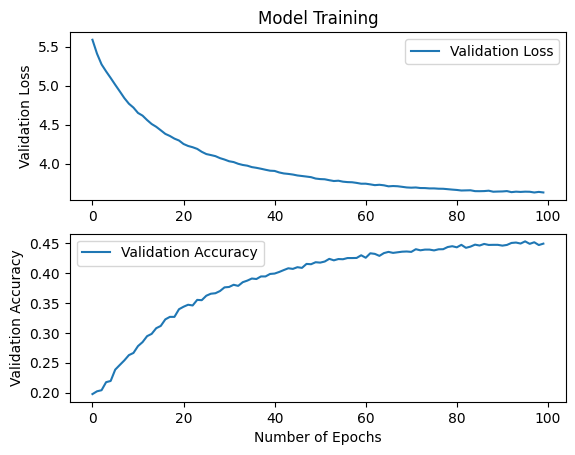

In [ ]:
dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)
model = prep_model('SweetNet', trained=False, num_classes=len(class_list))
optimizer_ft, scheduler, criterion = training_setup(model, 0.0005, num_classes = len(class_list))
model_ft_3 = train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100)

In [ ]:
torch.save(model_ft_3, '/content/SweetNet_species_10.pt')

In [15]:
model_ft_3 = torch.load('/content/isospec-internship/models/SweetNet_species_10.pt')
model_ft_3.eval()

SweetNet(
  (conv1): GraphConv(128, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (item_embedding): Embedding(2566, 128)
  (lin1): Linear(in_features=128, out_features=1024, bias=True)
  (lin2): Linear(in_features=1024, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=556, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (act2): LeakyReLU(negative_slope=0.01)
)

## 2.3 Embedding visualisation

In [16]:
glycans = df_data.groupby('glycan').agg({'Composition': lambda x : x,\
                                         'Species': lambda x : list(x),
                                         'tissue_sample': lambda x :x})\
                                  .reset_index()\
                                  .merge(df_N_glycans[['glycan', 'type']], on='glycan', how='outer')\
                                  .fillna({'type' : 'known'})
glycans = pd.concat([glycans, df_glycan_list]).reset_index(drop=True)

df_learned_rep = glycans_to_emb(glycans['glycan'].values, model_ft_3)

In [17]:
df_learned_rep_augm = df_learned_rep.merge(glycans, left_index=True, right_index=True)

In [ ]:
tsne_emb_1 = TSNE(random_state = 42).fit_transform(df_learned_rep_augm.drop(['glycan', 'type', 'tissue_sample', 'Species', 'Composition'], axis=1))

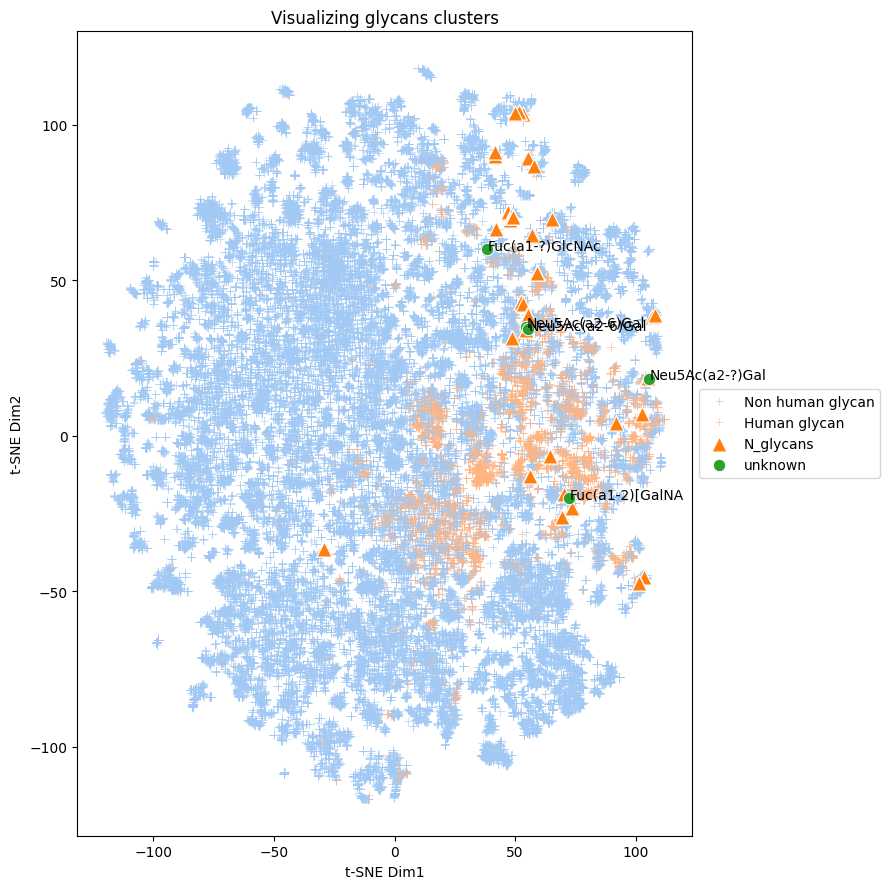

In [ ]:
df_plot = pd.DataFrame(tsne_emb_1).merge(glycans, left_index=True, right_index=True)
df_plot['from_human'] = df_plot['Species'].apply(lambda ss : 'Human glycan' if 'Homo_sapiens' in ss else 'Non human glycan')

plt.figure(figsize = (9, 9))
sns.scatterplot(data = df_plot[df_plot['type'] == 'known'], x =0 , y = 1,\
                s = 40, alpha = 0.8, hue='from_human',\
                marker='+', palette =sns.color_palette("pastel"))
sns.scatterplot(data = df_plot[df_plot['type'] == 'N_glycans'], x =0 , y = 1,\
                s = 120, alpha = 1,palette = ['red'],\
                marker='^', label='N_glycans')
fig = sns.scatterplot(data = df_plot[df_plot['type'] == 'unknown'], x =0 , y = 1,
                s = 80, alpha = 1,\
                palette = ['dark'], marker='o', label='unknown')
for i, point in df_plot.iterrows():
    if point['type'] == 'unknown':
        fig.text(point[0]+.02, point[1], str(point['glycan'])[:15] + '...')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Visualizing glycans clusters')
plt.tight_layout()

We can see from the cluster plot that N-linked glycans seem to cluster on the top right part of the graph, mostly on human glycan clusters. Our unknown glycans seem to belong to human glycans clusters.

## 2.4 Find neighbours

Find closest known glycans in the embedding space to unknown glycans.

I carefully chose the cosine distance or the Manhattan distance metrics as Euclidean distance metrics is not suited for high dimensions.
I search for a glycan neighbours as follow :
* Find the point where curve slope change on the log scale and define the cluster boundary
* define the cluster as all the points within the cluster boundary
This stage would need validation with other methods to see whether we end up with consistent clusters around the points of interest.

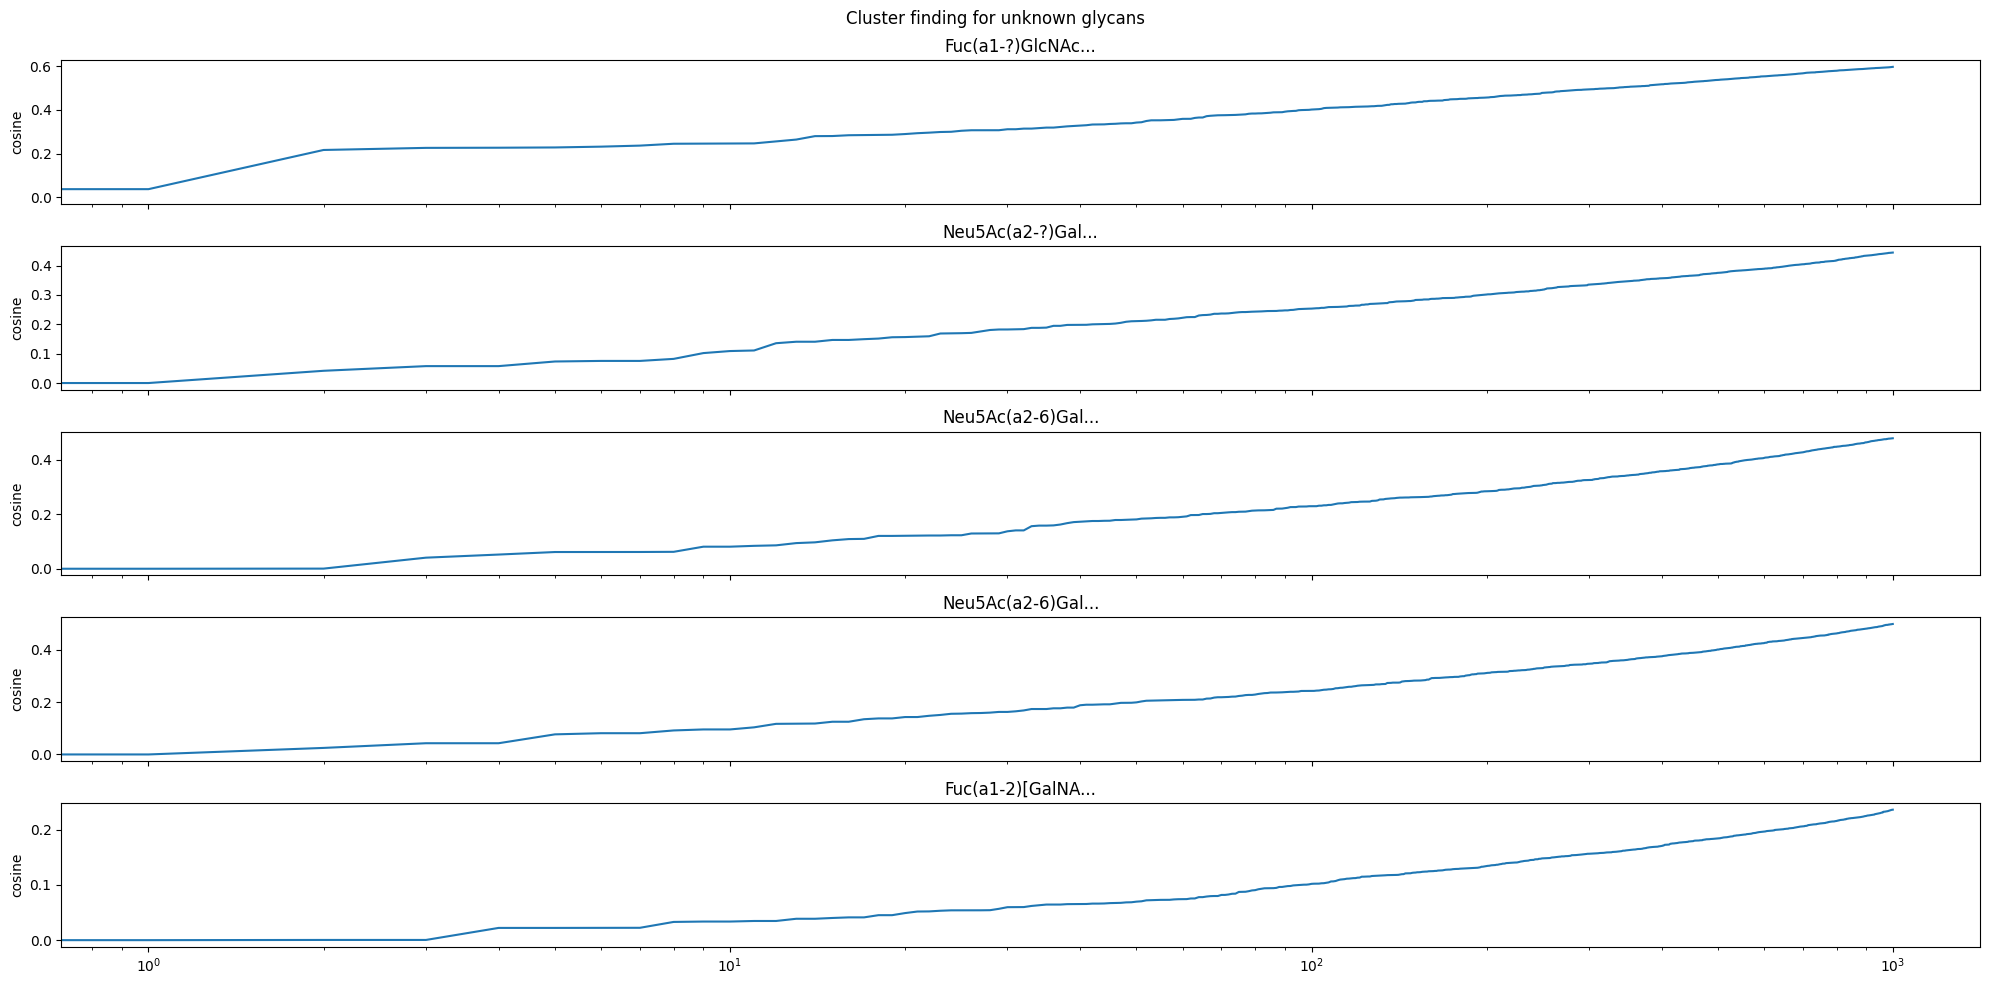

In [22]:
from scipy.spatial.distance import cdist

metric = 'cosine' #'cosine' #'cityblock'

df_reps = df_learned_rep_augm.set_index('glycan')\
          .drop(['type', 'tissue_sample', 'Species', 'Composition'], axis=1).T

fig, axs = plt.subplots(nrows=df_glycan_list.shape[1], sharex=True, figsize=(20,10))

for i, glycan in enumerate(df_glycan_list['glycan'].values):
  g_names = list(set(df_reps.columns) - set(glycan))
  vecs = df_reps[g_names].to_numpy()
  glyc_vec = np.expand_dims(df_reps[glycan].to_numpy(), axis=1)
  dist = cdist(glyc_vec.T, vecs.T, metric=metric).flatten()
  axs[i].plot(np.sort(dist)[:1000])
  axs[i].set_title(glycan[:15] + '...')
  axs[i].set_ylabel(metric)
  axs[i].set_xscale('log')

plt.suptitle('Cluster finding for unknown glycans')
plt.tight_layout()
plt.show()



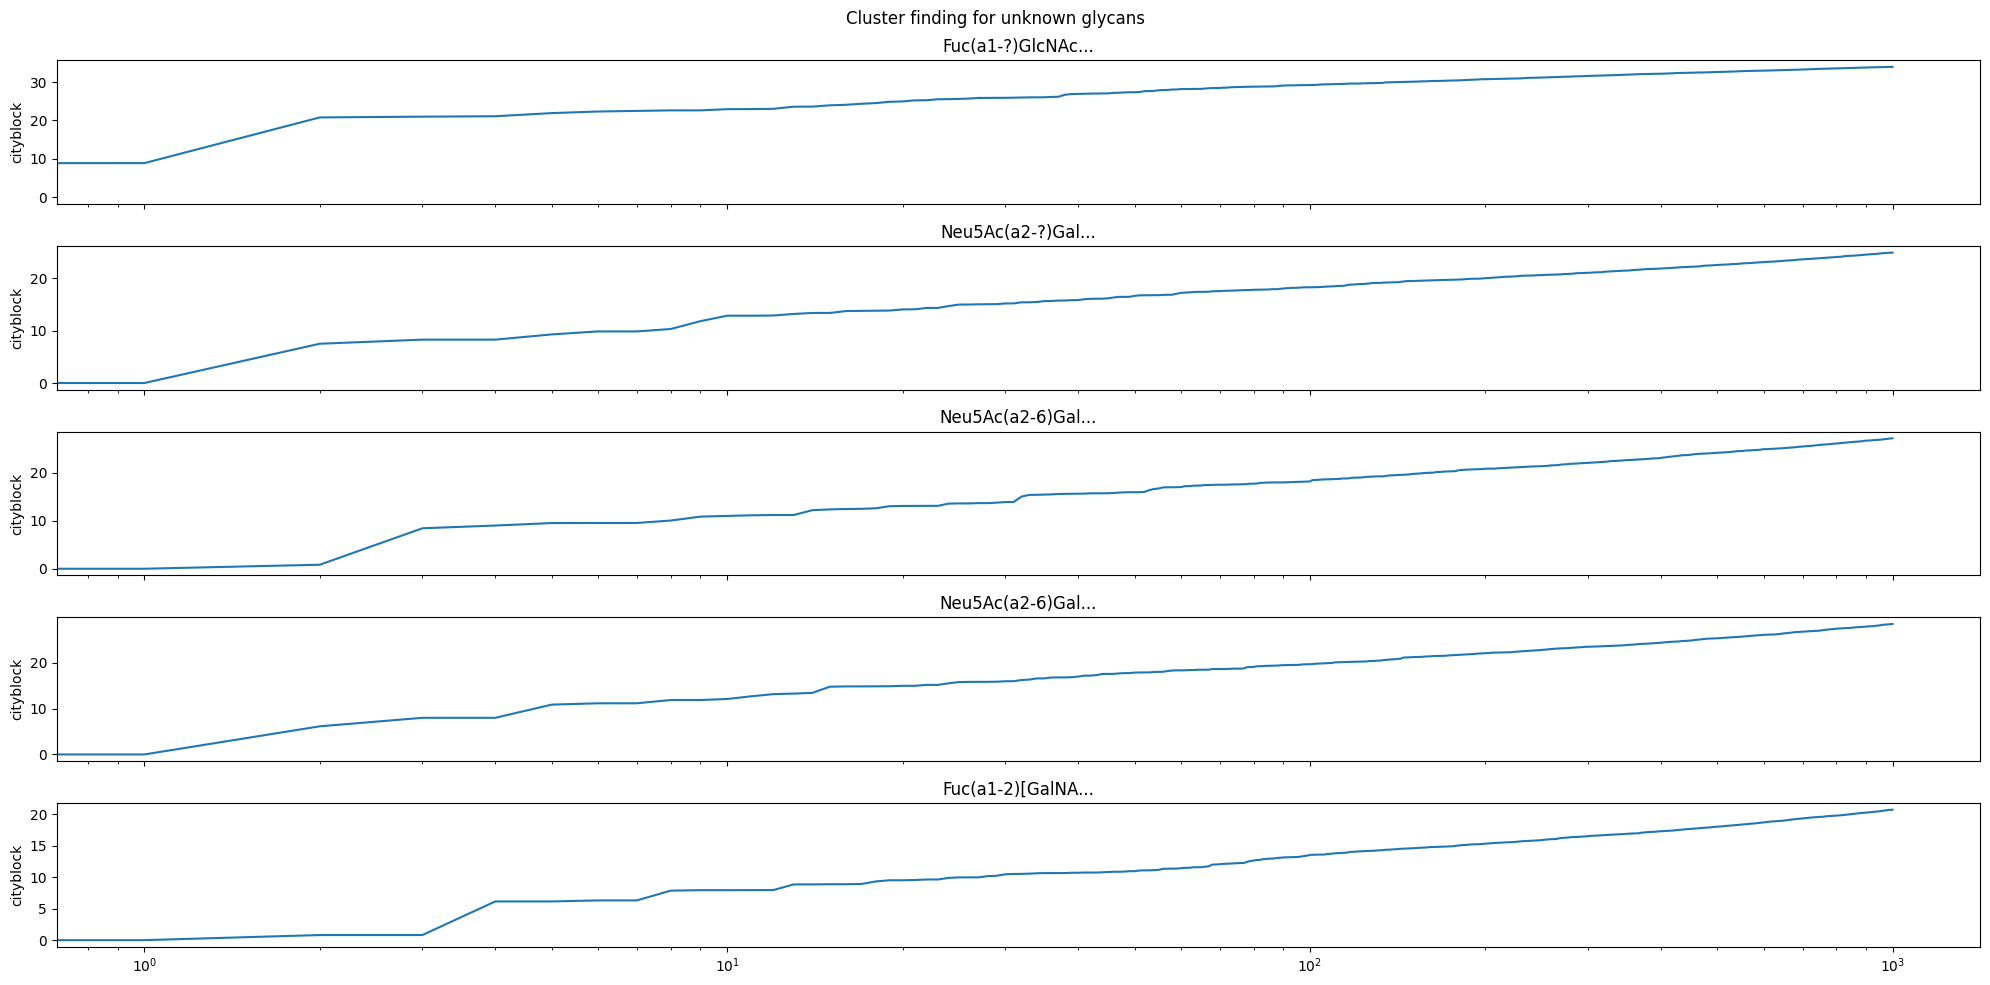

In [23]:
metric = 'cityblock' #'cosine' #'cityblock'

fig, axs = plt.subplots(nrows=df_glycan_list.shape[1], sharex=True, figsize=(20,10))

for i, glycan in enumerate(df_glycan_list['glycan'].values):

  vecs = df_reps[list(set(df_reps.columns) - set(glycan))].to_numpy()
  glyc_vec = np.expand_dims(df_reps[glycan].to_numpy(), axis=1)
  dist = cdist(glyc_vec.T, vecs.T, metric=metric).flatten()
  axs[i].plot(np.sort(dist)[:1000])
  axs[i].set_title(glycan[:15] + '...')
  axs[i].set_ylabel(metric)
  axs[i].set_xscale('log')

plt.suptitle('Cluster finding for unknown glycans')
plt.tight_layout()
plt.show()

Let's look for these clusters visually.
For the first and second glycan, this point seems to dwell around 10. It seems to be 100 for the third and fourth glycan.

In [31]:
metric='cosine'
neighbours=[]
dists = []
gly = []
for i, glycan in enumerate(df_glycan_list['glycan'].values):
  g_names = list(set(df_reps.columns) - set(glycan))
  vecs = df_reps[g_names].to_numpy()
  glyc_vec = np.expand_dims(df_reps[glycan].to_numpy(), axis=1)
  dist = cdist(glyc_vec.T, vecs.T, metric=metric).flatten()
  neighbours.extend([g_names[i] for i in dist.argsort()])
  dists.extend(list(dist))
  gly.extend([glycan]*len(g_names))

df_neighbours = pd.DataFrame({'neighbour':neighbours, 'distance':dists, 'glycan':gly})

In [38]:
df_neighbours = df_neighbours.merge(df_data[['Species', 'disease_association', 'glycan']], left_on='neighbour', right_on='glycan')\
                             .drop('glycan_y', axis=1).rename(columns={'glycan_x':'glycan'})
df_neighbours.shape

(322900, 5)

In [42]:
closest_neigbours = df_neighbours.sort_values(by=['distance', 'glycan']).groupby('glycan').head(100)
closest_neigbours

# TODO : on clustering remove non human glycan

,neighbour,distance,glycan,Species,disease_association
312429,GlcN1Vac(b1-4)GlcNAc(b1-4)GlcNAc(b1-4)GlcNAc(b...,0.000000e+00,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Sinorhizobium_sp,[]
55694,Glc(a1-6)[Glc(a1-2)]Glc(a1-6)Glc,0.000000e+00,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,Bifidobacterium_bifidum,[]
188870,Glc(a1-5)Kdo,0.000000e+00,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,NaN,[]
78439,Glc(?1-?)Fruf4Ac,0.000000e+00,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,NaN,[]
240846,GlcN(b1-4)[GlcN(b1-6)]GlcN(b1-3)[Glc(a1-6)]Man...,2.220446e-16,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,Brucella_abortus,[]
...,...,...,...,...,...
49797,Glc(b1-3)Glc(b1-3)Glc,3.565842e-01,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,Lyophyllum_decastes,[]
49798,Glc(b1-3)Glc(b1-3)Glc,3.565842e-01,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,Magnaporthe_oryzae,[]
49799,Glc(b1-3)Glc(b1-3)Glc,3.565842e-01,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,Neurospora_crassa,[]
49800,Glc(b1-3)Glc(b1-3)Glc,3.565842e-01,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,Paracoccidioides_brasiliensis,[]


## 2.4 Use pre-trained embedding to compare with our embedding

In [ ]:
model_pret = prep_model(model_type = 'SweetNet', num_classes=1011, trained=True)

In [ ]:
from glycowork.motif.analysis import plot_embeddings


embds = glycans_to_emb(glycans['glycan'].values.tolist(), model_pret, class_list=class_list)

In [ ]:
df_learned_rep_augm_2 = embds.merge(glycans, left_index=True, right_index=True)
tsne_emb_2 = TSNE(random_state = 42).fit_transform(df_learned_rep_augm_2.drop(['glycan', 'type', 'tissue_sample', 'Species', 'Composition'], axis=1))

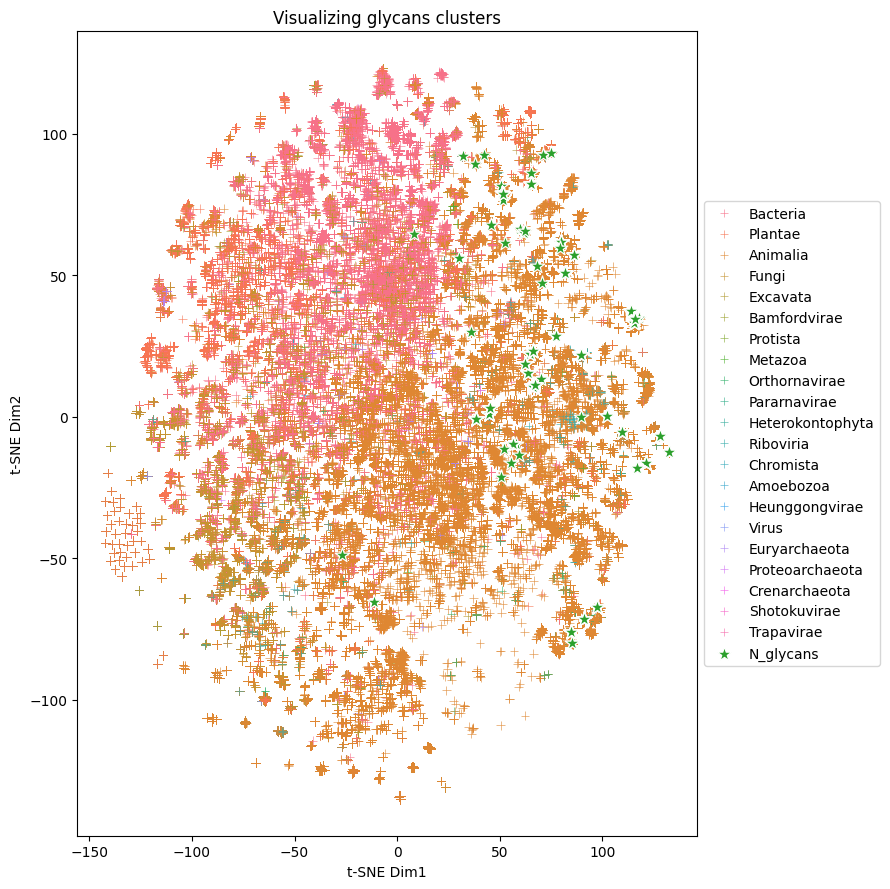

In [ ]:
df_plot = pd.DataFrame(tsne_emb_2).merge(glycans, left_index=True, right_index=True)\
                                  .merge(df_data[['glycan', 'Kingdom']].explode('Kingdom'), on='glycan')
df_plot['from_human'] = df_plot['Species'] == 'Homo_sapiens'
plt.figure(figsize = (9, 9))
custom_colors = {'unknown': 'red', 'known':'black', 'N_glycans':'blue' }
custom_markers = {'unknown': 'X', 'known':'^', 'N_glycans':'*' }
sns.scatterplot(data = df_plot[df_plot['type'] == 'known'], x =0 , y = 1,\
                s = 40, alpha = 0.8, hue='Kingdom', marker='+')
sns.scatterplot(data = df_plot[df_plot['type'] == 'unknown'], x =0 , y = 1,\
                s = 30, alpha = 1,palette = ['black'], marker='o', label='unknown')
sns.scatterplot(data = df_plot[df_plot['type'] == 'N_glycans'], x =0 , y = 1,\
                s = 120, alpha = 1,palette = ['green'], marker='*', label='N_glycans')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Visualizing glycans clusters')
plt.tight_layout()

We can see that N glycans form tigher clusters.